In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load and analyze the dataset
df = pd.read_csv(r'D:\farrell2\intentionBERT\intent_hamil.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nUnique intents: {df['intent'].nunique()}")
print(f"Intent distribution:")
print(df['intent'].value_counts())

Dataset shape: (1225, 2)

Columns: ['text', 'intent']

First few rows:
                                                text  \
0        Kapan jadwal kontrol hamil saya berikutnya?   
1        Tolong ingatkan saya ANC selanjutnya kapan.   
2  Saya mau tahu kontrol kehamilan berikutnya kapan.   
3  Kapan saya harus datang lagi untuk pemeriksaan...   
4         Ada jadwal kunjungan ANC saya selanjutnya?   

                       intent  
0  reminder_kontrol_kehamilan  
1  reminder_kontrol_kehamilan  
2  reminder_kontrol_kehamilan  
3  reminder_kontrol_kehamilan  
4  reminder_kontrol_kehamilan  

Unique intents: 6
Intent distribution:
intent
reminder_kontrol_kehamilan      258
riwayat_suplemen_kehamilan      206
riwayat_persalinan              204
imunisasi_tracker               204
anc_tracker                     202
panduan_persiapan_persalinan    151
Name: count, dtype: int64


In [18]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# Display label mapping
label_mapping = dict(zip(df['intent'], df['label']))
print("Label mapping:")
for intent, label in label_mapping.items():
    print(f"{intent}: {label}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Custom Dataset class
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Label mapping:
reminder_kontrol_kehamilan: 3
anc_tracker: 0
imunisasi_tracker: 1
riwayat_persalinan: 4
riwayat_suplemen_kehamilan: 5
panduan_persiapan_persalinan: 2

Training samples: 980
Testing samples: 245


In [19]:
# Save test set to CSV
df_test = pd.DataFrame({'text': X_test, 'label': y_test})
df_test['intent'] = label_encoder.inverse_transform(df_test['label'].values)

file_path = 'test_hamil.csv'
df_test.to_csv(file_path, index=False, encoding='utf-8-sig')

print(f"Saved test set to {file_path} (shape: {df_test.shape})")
print(df_test.head())

Saved test set to test_hamil.csv (shape: (245, 3))
                                                text  label  \
0   Tampilkan informasi vaksin yang pernah diberikan      1   
1       Tolong periksa tekanan darah di minggu ke 32      0   
2          Bisa tampilkan grafik tinggi fundus saya?      0   
3                  Ada catatan lahiran anak pertama?      4   
4  Peralatan bayi apa yang harus sudah disiapkan ...      2   

                         intent  
0             imunisasi_tracker  
1                   anc_tracker  
2                   anc_tracker  
3            riwayat_persalinan  
4  panduan_persiapan_persalinan  


In [20]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Load IndoBERT model and tokenizer
model_name = "indobenchmark/indobert-base-p1"
print(f"Loading IndoBERT model: {model_name}")

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_encoder.classes_)
    )
    
    # Move model to device
    model = model.to(device)
    
    print(f"Model loaded successfully!")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Validate data before creating datasets
print(f"\nValidating data...")
empty_texts = [i for i, text in enumerate(X_train) if not text or str(text).strip() == '']
if empty_texts:
    print(f"Warning: Found {len(empty_texts)} empty texts in training data")

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nClass distribution in training data:")
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({label_encoder.inverse_transform([cls])[0]}): {count} samples")

# Create datasets
train_dataset = IntentDataset(X_train, y_train, tokenizer)
test_dataset = IntentDataset(X_test, y_test, tokenizer)

print(f"\nDataset creation completed:")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.0 GB
Loading IndoBERT model: indobenchmark/indobert-base-p1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Number of classes: 6
Model parameters: 124,445,958

Validating data...

Class distribution in training data:
  Class 0 (anc_tracker): 162 samples
  Class 1 (imunisasi_tracker): 163 samples
  Class 2 (panduan_persiapan_persalinan): 121 samples
  Class 3 (reminder_kontrol_kehamilan): 206 samples
  Class 4 (riwayat_persalinan): 163 samples
  Class 5 (riwayat_suplemen_kehamilan): 165 samples

Dataset creation completed:
Training dataset size: 980
Test dataset size: 245


In [21]:
# Determine optimal batch size based on available memory
def get_optimal_batch_size():
    if torch.cuda.is_available():
        # Get GPU memory in GB
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        if gpu_memory_gb >= 8:
            return 16
        elif gpu_memory_gb >= 4:
            return 8
        else:
            return 4
    else:
        return 4  # Conservative for CPU

batch_size = get_optimal_batch_size()
print(f"Using batch size: {batch_size}")

# Define training arguments with improved configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Increased from 3 to 5
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # Changed to accuracy for better model selection
    greater_is_better=True,
    seed=42,
    fp16=torch.cuda.is_available(),  # Enable fp16 if GPU is available
    learning_rate=2e-5,  # Explicit learning rate
    lr_scheduler_type="cosine",  # Better learning rate scheduling
    save_total_limit=3,  # Limit saved checkpoints to save disk space
    report_to=None,  # Disable wandb/tensorboard logging if not needed
    dataloader_num_workers=0,  # Set to 0 to avoid multiprocessing issues on Windows
)

# Define metrics function with additional metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer configured successfully!")
print(f"Training will use {len(train_dataset)} training samples and {len(test_dataset)} validation samples")
print(f"Expected training time: ~{len(train_dataset) // batch_size * training_args.num_train_epochs // 60} minutes")

Using batch size: 16
Trainer configured successfully!
Training will use 980 training samples and 245 validation samples
Expected training time: ~5 minutes


C:\Users\User\AppData\Local\Temp\ipykernel_27740\1216211371.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
# Start training with error handling
print("Starting training...")
print("This may take several minutes depending on your hardware.")
print(f"Training on device: {device}")

try:
    # Clear any cached memory before training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
    train_result = trainer.train()
    
    print("\nTraining completed successfully!")
    print(f"Training loss: {train_result.training_loss:.4f}")
    print(f"Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
    print(f"Training samples per second: {train_result.metrics['train_samples_per_second']:.2f}")
    
    if torch.cuda.is_available():
        print(f"GPU memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
except Exception as e:
    print(f"Training failed with error: {e}")
    print("This might be due to:")
    print("1. Insufficient GPU/CPU memory - try reducing batch size")
    print("2. CUDA out of memory - try setting fp16=False")
    print("3. Model loading issues - check internet connection")
    raise

# Evaluate the model
print("\nEvaluating model...")
try:
    eval_result = trainer.evaluate()
    print(f"Evaluation loss: {eval_result['eval_loss']:.4f}")
    print(f"Evaluation accuracy: {eval_result['eval_accuracy']:.4f}")
    print(f"Evaluation F1-score: {eval_result['eval_f1']:.4f}")
    print(f"Evaluation precision: {eval_result['eval_precision']:.4f}")
    print(f"Evaluation recall: {eval_result['eval_recall']:.4f}")
    
except Exception as e:
    print(f"Evaluation failed with error: {e}")
    raise

Starting training...
This may take several minutes depending on your hardware.
Training on device: cuda
GPU memory before training: 0.49 GB


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.581200,1.490362,0.518367,0.450992,0.605264,0.518367
2,0.978900,0.783812,0.885714,0.885168,0.907481,0.885714
3,0.112700,0.054227,0.995918,0.995924,0.996018,0.995918
4,0.033800,0.009655,1.000000,1.000000,1.000000,1.000000
5,0.006200,0.004925,1.000000,1.000000,1.000000,1.000000



Training completed successfully!
Training loss: 0.6729
Training runtime: 60.65 seconds
Training samples per second: 80.80
GPU memory after training: 1.42 GB

Evaluating model...


Evaluation loss: 0.0097
Evaluation accuracy: 1.0000
Evaluation F1-score: 1.0000
Evaluation precision: 1.0000
Evaluation recall: 1.0000


In [30]:
# Save the trained model with proper cleanup for Windows
print("Saving the trained model...")

# First, let's clean up any memory-mapped files and force garbage collection
import gc
import time

try:
    # Clear GPU cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Force garbage collection to release any file handles
    gc.collect()
    
    # Wait a moment for Windows to release file handles
    time.sleep(1)
    
    # Save the model and tokenizer to a different directory to avoid conflicts
    model_save_path = "./final_trained_model"
    
    # Method 1: Use the model directly instead of trainer.save_model()
    print(f"Saving model to {model_save_path}...")
    
    # Create the directory if it doesn't exist
    import os
    os.makedirs(model_save_path, exist_ok=True)
    
    # Save model components individually
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    
    # Save label encoder
    import pickle
    with open(f"{model_save_path}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    
    # Save additional metadata
    import json
    metadata = {
        "model_name": model_name,
        "num_classes": len(label_encoder.classes_),
        "class_names": label_encoder.classes_.tolist(),
        "training_accuracy": eval_result['eval_accuracy'],
        "training_loss": eval_result['eval_loss']
    }
    
    with open(f"{model_save_path}/training_metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Model saved successfully to {model_save_path}")
    
    # Test model loading (validation) with a slight delay
    time.sleep(2)  # Give Windows time to release file handles
    print("Validating saved model...")
    
    test_tokenizer = AutoTokenizer.from_pretrained(model_save_path)
    test_model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
    
    # Load label encoder
    with open(f"{model_save_path}/label_encoder.pkl", "rb") as f:
        test_label_encoder = pickle.load(f)
    
    print("Model validation successful - saved model can be loaded correctly")
    print(f"Validated model has {test_model.config.num_labels} classes")
    print(f"Label encoder classes: {test_label_encoder.classes_}")
    
except Exception as e:
    print(f"Error saving model: {e}")
    print("Trying alternative saving method...")
    
    try:
        # Alternative method: Copy from the results directory
        import shutil
        
        # Find the best checkpoint directory
        results_dir = "./results"
        if os.path.exists(results_dir):
            checkpoints = [d for d in os.listdir(results_dir) if d.startswith("checkpoint-")]
            if checkpoints:
                # Get the latest checkpoint (highest number)
                latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("-")[1]))
                checkpoint_path = os.path.join(results_dir, latest_checkpoint)
                
                # Copy the checkpoint to our final model directory
                alternative_save_path = "./final_model_backup"
                if os.path.exists(alternative_save_path):
                    shutil.rmtree(alternative_save_path)
                shutil.copytree(checkpoint_path, alternative_save_path)
                
                # Copy tokenizer files
                tokenizer.save_pretrained(alternative_save_path)
                
                # Save label encoder
                with open(f"{alternative_save_path}/label_encoder.pkl", "wb") as f:
                    pickle.dump(label_encoder, f)
                
                print(f"Alternative save successful to {alternative_save_path}")
                print(f"Used checkpoint: {latest_checkpoint}")
                
            else:
                print("No checkpoints found in results directory")
        else:
            print("Results directory not found")
            
    except Exception as e2:
        print(f"Alternative saving also failed: {e2}")
        print("The model is still loaded in memory and can be used for predictions")

# Quick prediction test (this should work regardless of saving issues)
print("\nTesting model with sample predictions...")
test_texts = [
    "Saya merasa mual dan pusing",
    "kapan jadwal anc saya yang berikutnya?",
    "Kapan waktu yang tepat untuk pemeriksaan kehamilan", 
    "Bagaimana cara menjaga kesehatan selama hamil",
    "Saya ingin melihat catatan ANC terbaru"
]

try:
    model.eval()  # Set to evaluation mode
    for text in test_texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=-1).item()
            confidence = predictions[0][predicted_class].item()
            
        predicted_intent = label_encoder.inverse_transform([predicted_class])[0]
        print(f"Text: '{text}'")
        print(f"Predicted: {predicted_intent} (confidence: {confidence:.4f})")
        print("-" * 50)
        
except Exception as e:
    print(f"Error in prediction test: {e}")

# List saved files to confirm what was saved
try:
    saved_paths = ["./final_trained_model", "./final_model_backup", "./results"]
    for path in saved_paths:
        if os.path.exists(path):
            print(f"\nContents of {path}:")
            if os.path.isdir(path):
                for item in os.listdir(path):
                    item_path = os.path.join(path, item)
                    if os.path.isfile(item_path):
                        size = os.path.getsize(item_path) / (1024*1024)  # Size in MB
                        print(f"  {item} ({size:.1f} MB)")
                    elif os.path.isdir(item_path):
                        print(f"  {item}/ (directory)")
            break  # Only show the first existing directory
except Exception as e:
    print(f"Error listing files: {e}")

Saving the trained model...
Saving model to ./final_trained_model...
Error saving model: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "The requested operation cannot be performed on a file with a user-mapped section open." })
Trying alternative saving method...
Saving model to ./final_trained_model...
Error saving model: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "The requested operation cannot be performed on a file with a user-mapped section open." })
Trying alternative saving method...
Alternative save successful to ./final_model_backup
Used checkpoint: checkpoint-980

Testing model with sample predictions...
Text: 'Saya merasa mual dan pusing'
Predicted: anc_tracker (confidence: 0.9827)
--------------------------------------------------
Text: 'kapan jadwal anc saya yang berikutnya?'
Predicted: reminder_kontrol_kehamilan (confidence: 0.9936)
--------------------------------------------------
Text: 'Kapan waktu y

In [27]:
# Utility function to load the trained model for future use
def load_trained_model(model_path="./final_trained_model"):
    """
    Load the trained intent classification model
    
    Args:
        model_path (str): Path to the saved model directory
        
    Returns:
        tuple: (model, tokenizer, label_encoder, metadata)
    """
    import os
    import pickle
    import json
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    
    try:
        # Check if the directory exists
        if not os.path.exists(model_path):
            # Try alternative path
            alternative_paths = ["./final_model_backup", "./results/checkpoint-980", "./results"]
            for alt_path in alternative_paths:
                if os.path.exists(alt_path):
                    model_path = alt_path
                    print(f"Using alternative model path: {model_path}")
                    break
            else:
                raise FileNotFoundError(f"No model found in any expected location")
        
        print(f"Loading model from: {model_path}")
        
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        
        # Load label encoder
        label_encoder_path = os.path.join(model_path, "label_encoder.pkl")
        if os.path.exists(label_encoder_path):
            with open(label_encoder_path, "rb") as f:
                label_encoder = pickle.load(f)
        else:
            print("Warning: label_encoder.pkl not found, creating from current session")
            label_encoder = globals().get('label_encoder', None)
            if label_encoder is None:
                raise FileNotFoundError("Label encoder not available")
        
        # Load metadata if available
        metadata_path = os.path.join(model_path, "training_metadata.json")
        metadata = {}
        if os.path.exists(metadata_path):
            with open(metadata_path, "r") as f:
                metadata = json.load(f)
        
        print("Model loaded successfully!")
        print(f"Number of classes: {model.config.num_labels}")
        print(f"Class names: {label_encoder.classes_}")
        
        if metadata:
            print(f"Training accuracy: {metadata.get('training_accuracy', 'N/A')}")
            print(f"Training loss: {metadata.get('training_loss', 'N/A')}")
        
        return model, tokenizer, label_encoder, metadata
        
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Example of how to use the loading function
print("Model loading function created. You can use it like this:")
print("loaded_model, loaded_tokenizer, loaded_label_encoder, metadata = load_trained_model()")
print("\n" + "="*60)

Model loading function created. You can use it like this:
loaded_model, loaded_tokenizer, loaded_label_encoder, metadata = load_trained_model()



In [ ]:
# Enhanced model saving with different options
def save_model_complete(save_inference_only=True, save_full_training_state=False):
    """
    Save the trained model with different options
    
    Args:
        save_inference_only (bool): Save only model weights for inference (smaller size)
        save_full_training_state (bool): Save complete training state including optimizer and scheduler
    """
    import gc
    import time
    import os
    import pickle
    import json
    import shutil
    
    print("="*60)
    print("ENHANCED MODEL SAVING")
    print("="*60)
    
    # Clear memory first
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    time.sleep(1)
    
    if save_inference_only:
        print("\n1. Saving INFERENCE-ONLY model (recommended for deployment)...")
        try:
            model_save_path = "./final_trained_model"
            os.makedirs(model_save_path, exist_ok=True)
            
            # Save only model and tokenizer (for inference)
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
            
            # Save label encoder
            with open(f"{model_save_path}/label_encoder.pkl", "wb") as f:
                pickle.dump(label_encoder, f)
            
            # Save metadata
            metadata = {
                "model_name": model_name,
                "num_classes": len(label_encoder.classes_),
                "class_names": label_encoder.classes_.tolist(),
                "training_accuracy": eval_result['eval_accuracy'],
                "training_loss": eval_result['eval_loss'],
                "training_f1": eval_result['eval_f1'],
                "save_type": "inference_only",
                "files_included": ["model weights", "tokenizer", "label_encoder", "metadata"]
            }
            
            with open(f"{model_save_path}/training_metadata.json", "w") as f:
                json.dump(metadata, f, indent=2)
            
            # Calculate and display file sizes
            total_size = 0
            print(f"   Saved to: {model_save_path}")
            print("   Files saved:")
            for item in os.listdir(model_save_path):
                item_path = os.path.join(model_save_path, item)
                if os.path.isfile(item_path):
                    size_mb = os.path.getsize(item_path) / (1024*1024)
                    total_size += size_mb
                    print(f"     - {item}: {size_mb:.1f} MB")
            
            print(f"   Total size: {total_size:.1f} MB")
            print("   ✓ Perfect for inference and deployment!")
            
        except Exception as e:
            print(f"   ✗ Error: {e}")
    
    if save_full_training_state:
        print(f"\n2. Saving FULL TRAINING STATE (includes optimizer.pt and scheduler.pt)...")
        try:
            full_save_path = "./complete_training_checkpoint"
            
            # Use trainer.save_model to save everything
            trainer.save_model(full_save_path)
            
            # Also save label encoder and metadata
            with open(f"{full_save_path}/label_encoder.pkl", "wb") as f:
                pickle.dump(label_encoder, f)
            
            metadata_full = {
                "model_name": model_name,
                "num_classes": len(label_encoder.classes_),
                "class_names": label_encoder.classes_.tolist(),
                "training_accuracy": eval_result['eval_accuracy'],
                "training_loss": eval_result['eval_loss'],
                "training_f1": eval_result['eval_f1'],
                "save_type": "complete_checkpoint",
                "files_included": ["model weights", "optimizer state", "scheduler state", "tokenizer", "label_encoder", "training_args", "metadata"]
            }
            
            with open(f"{full_save_path}/training_metadata.json", "w") as f:
                json.dump(metadata_full, f, indent=2)
            
            # Calculate and display file sizes
            total_size_full = 0
            print(f"   Saved to: {full_save_path}")
            print("   Files saved:")
            for item in os.listdir(full_save_path):
                item_path = os.path.join(full_save_path, item)
                if os.path.isfile(item_path):
                    size_mb = os.path.getsize(item_path) / (1024*1024)
                    total_size_full += size_mb
                    print(f"     - {item}: {size_mb:.1f} MB")
            
            print(f"   Total size: {total_size_full:.1f} MB")
            print("   ✓ Includes optimizer.pt and scheduler.pt for resuming training!")
            
        except Exception as e:
            print(f"   ✗ Error: {e}")
            
            # Fallback: copy from results directory
            try:
                print("   Trying fallback method...")
                results_dir = "./results"
                if os.path.exists(results_dir):
                    checkpoints = [d for d in os.listdir(results_dir) if d.startswith("checkpoint-")]
                    if checkpoints:
                        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("-")[1]))
                        checkpoint_path = os.path.join(results_dir, latest_checkpoint)
                        
                        fallback_path = "./complete_training_checkpoint_backup"
                        if os.path.exists(fallback_path):
                            shutil.rmtree(fallback_path)
                        shutil.copytree(checkpoint_path, fallback_path)
                        
                        # Add our custom files
                        with open(f"{fallback_path}/label_encoder.pkl", "wb") as f:
                            pickle.dump(label_encoder, f)
                        
                        print(f"   ✓ Fallback successful to: {fallback_path}")
                        print(f"   ✓ This includes optimizer.pt and scheduler.pt!")
                    
    print(f"\n" + "="*60)
    print("SAVE SUMMARY:")
    print("="*60)
    
    saved_locations = []
    for path in ["./final_trained_model", "./complete_training_checkpoint", "./complete_training_checkpoint_backup"]:
        if os.path.exists(path):
            total_size = sum(os.path.getsize(os.path.join(path, f)) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))) / (1024*1024)
            
            # Check what files are included
            files = os.listdir(path)
            has_optimizer = "optimizer.pt" in files
            has_scheduler = "scheduler.pt" in files
            
            print(f"📁 {path}:")
            print(f"   Size: {total_size:.1f} MB")
            print(f"   Optimizer: {'✓' if has_optimizer else '✗'}")
            print(f"   Scheduler: {'✓' if has_scheduler else '✗'}")
            print(f"   Use for: {'Training resumption' if has_optimizer else 'Inference/Deployment'}")
            saved_locations.append(path)
    
    return saved_locations

# Run the enhanced saving function
print("Choose what to save:")
print("1. Inference-only (smaller, no optimizer.pt/scheduler.pt) - RECOMMENDED")
print("2. Full training state (larger, includes optimizer.pt/scheduler.pt)")
print("3. Both")

# Save both by default to give you options
saved_paths = save_model_complete(
    save_inference_only=True,      # For deployment/inference
    save_full_training_state=True  # For resuming training
)

## 📋 Understanding Model Files: When Do You Need optimizer.pt and scheduler.pt?

### **Files Explanation:**

| File | Size | Purpose | When Needed |
|------|------|---------|-------------|
| **model.safetensors** | ~400MB | Model weights | ✅ Always (inference + training) |
| **config.json** | <1MB | Model configuration | ✅ Always |
| **tokenizer files** | <5MB | Text tokenization | ✅ Always |
| **optimizer.pt** | ~800MB | Optimizer state (Adam momentum, etc.) | 🔄 Only for resuming training |
| **scheduler.pt** | <1MB | Learning rate scheduler state | 🔄 Only for resuming training |

### **When to Save What:**

#### 🚀 **For Inference/Deployment (Recommended):**
```python
# Only need: model weights + tokenizer + config
# Size: ~400MB
# Files: model.safetensors, config.json, tokenizer.json, vocab.txt
```
- **Use when:** Deploying to production, sharing model, making predictions
- **Advantages:** Smaller size, faster loading, cleaner
- **Missing:** optimizer.pt, scheduler.pt (not needed for inference)

#### 🔄 **For Resuming Training:**
```python
# Need: everything including optimizer and scheduler states  
# Size: ~1.2GB
# Files: All above + optimizer.pt + scheduler.pt + trainer_state.json
```
- **Use when:** You want to continue training from this checkpoint
- **Advantages:** Can resume training exactly where you left off
- **Disadvantages:** 3x larger file size

### **Why This Matters:**
- **optimizer.pt** contains the Adam optimizer's momentum and variance estimates for each parameter
- **scheduler.pt** contains the current learning rate schedule position
- **Without these:** You can still use the model for predictions, but can't resume training optimally

### **Bottom Line:**
- ✅ **Most users need INFERENCE-ONLY saves** (no optimizer.pt/scheduler.pt)
- 🔄 **Only save full state if you plan to resume training later**

Generating predictions for confusion matrix...



CLASSIFICATION REPORT
                              precision    recall  f1-score   support

                 anc_tracker     1.0000    1.0000    1.0000        40
           imunisasi_tracker     1.0000    1.0000    1.0000        41
panduan_persiapan_persalinan     1.0000    1.0000    1.0000        30
  reminder_kontrol_kehamilan     1.0000    1.0000    1.0000        52
          riwayat_persalinan     1.0000    1.0000    1.0000        41
  riwayat_suplemen_kehamilan     1.0000    1.0000    1.0000        41

                    accuracy                         1.0000       245
                   macro avg     1.0000    1.0000    1.0000       245
                weighted avg     1.0000    1.0000    1.0000       245


CONFUSION MATRIX (Counts)
Predicted ->
Actual ↓

Class mapping:
0: anc_tracker
1: imunisasi_tracker
2: panduan_persiapan_persalinan
3: reminder_kontrol_kehamilan
4: riwayat_persalinan
5: riwayat_suplemen_kehamilan

Confusion Matrix:
[[40  0  0  0  0  0]
 [ 0 41  0  0  0  0

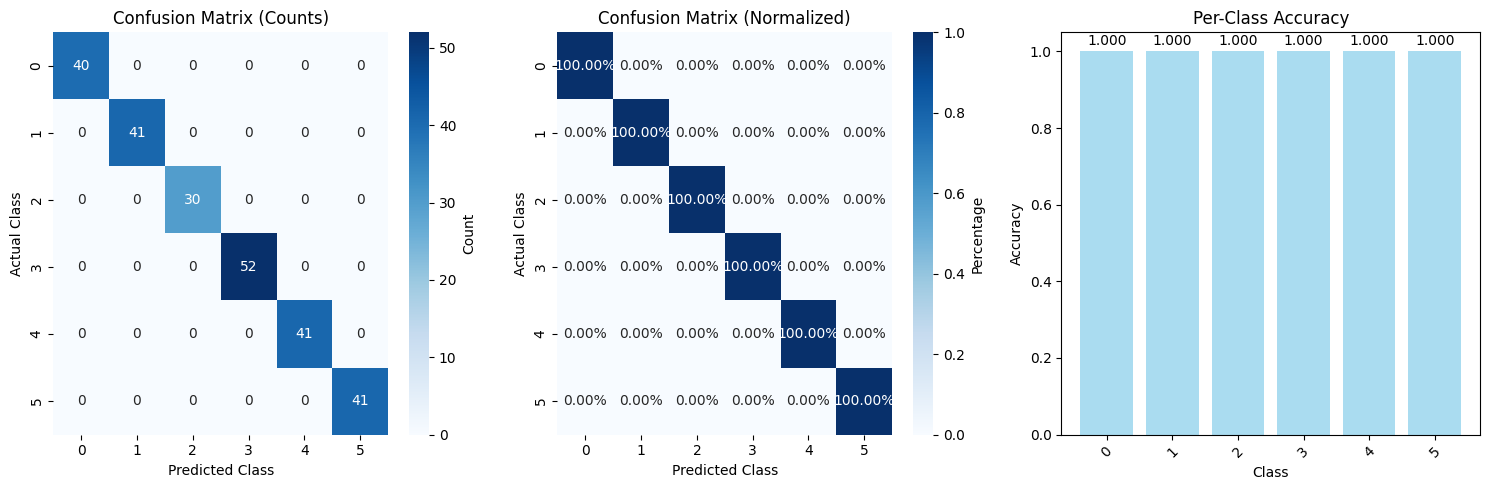


DETAILED CONFUSION MATRIX WITH CLASS NAMES
Predicted ->
                              anc_tracker  imunisasi_tracker  \
anc_tracker                            40                  0   
imunisasi_tracker                       0                 41   
panduan_persiapan_persalinan            0                  0   
reminder_kontrol_kehamilan              0                  0   
riwayat_persalinan                      0                  0   
riwayat_suplemen_kehamilan              0                  0   

                              panduan_persiapan_persalinan  \
anc_tracker                                              0   
imunisasi_tracker                                        0   
panduan_persiapan_persalinan                            30   
reminder_kontrol_kehamilan                               0   
riwayat_persalinan                                       0   
riwayat_suplemen_kehamilan                               0   

                              reminder_kontrol_kehamilan  r

In [28]:
# Generate predictions on test set for confusion matrix
print("Generating predictions for confusion matrix...")

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(y_test)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = [label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))]

# Create a more readable confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Print confusion matrix in numbers
print("\n" + "="*50)
print("CONFUSION MATRIX (Counts)")
print("="*50)
print("Predicted ->")
print("Actual ↓")
print("\nClass mapping:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")
print(f"\nConfusion Matrix:\n{cm}")

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix with counts
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(len(class_names)), 
            yticklabels=range(len(class_names)),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Plot 2: Normalized confusion matrix (percentages)
plt.subplot(1, 3, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=range(len(class_names)), 
            yticklabels=range(len(class_names)),
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Plot 3: Per-class accuracy
plt.subplot(1, 3, 3)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.bar(range(len(class_names)), per_class_acc, color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(len(class_names)), rotation=45)
for i, acc in enumerate(per_class_acc):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix with class names
print("\n" + "="*80)
print("DETAILED CONFUSION MATRIX WITH CLASS NAMES")
print("="*80)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Predicted ->")
print(cm_df)

print("\n" + "="*50)
print("PER-CLASS METRICS")
print("="*50)
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - true_positives
    false_negatives = cm[i, :].sum() - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Support: {cm[i, :].sum()}")

# Overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correctly Classified: {(y_pred == y_true).sum()}")
print(f"Misclassified: {(y_pred != y_true).sum()}")